# Radar Data Streaming and Pre-Processing

### This notebook demonstrates how to read the data from the radar using python wrapper for Infineon Radar SDK

#### Importing required libraries 

    - ifxdaq --> is the python wrapper for Radar SDK
    - processing --> is python module for basic processing to get the range-Dopplers from the signal
    - fft --> contains the range_fft and doppler_fft methods
    

In [142]:
import ifxdaq
import processing
import pandas as pd
import numpy as np
#print(ifxdaq.__version__)
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plot

#### In the folder 'radar_configs' you find radar configuration parameters. It contains radar parameters :

    - transmit power level
    - start/end frequency
    - sampling rate
    - # of chirps per frame
    - # of samples per chirp
    - # of transmit/receive antennas
    - MIMO mode selection

In [143]:
config_file = "radar_configs/RadarIfxBGT60.json"
number_of_frames = 3000

In [144]:
## Run this to understand the current radar settings better
import json
with open(config_file) as json_file:
    c = json.load(json_file)["device_config"]["fmcw_single_shape"]
    chirp_duration = c["num_samples_per_chirp"]/c['sample_rate_Hz']
    frame_duration = (chirp_duration + c['chirp_repetition_time_s']) * c['num_chirps_per_frame']
    print("With the current configuration, the radar will send out " + str(c['num_chirps_per_frame']) + \
          ' signals with varying frequency ("chirps") between ' + str(c['start_frequency_Hz']/1e9) + " GHz and " + \
          str(c['end_frequency_Hz']/1e9) + " GHz.")
    print('Each chirp will consist of ' + str(c["num_samples_per_chirp"]) + ' ADC measurements of the IF signal ("samples").')
    print('A chirp takes ' + str(chirp_duration*1e6) + ' microseconds and the delay between the chirps is ' + str(c['chirp_repetition_time_s']*1e6) +' microseconds.')
    print('With a total frame duration of ' + str(frame_duration*1e3) + ' milliseconds and a delay of ' + str(c['frame_repetition_time_s']*1e3) + ' milliseconds between the frame we get a frame rate of ' + str(1/(frame_duration + c['frame_repetition_time_s'])) + ' radar frames per second.')

With the current configuration, the radar will send out 64 signals with varying frequency ("chirps") between 60.5 GHz and 61.5 GHz.
Each chirp will consist of 128 ADC measurements of the IF signal ("samples").
A chirp takes 64.0 microseconds and the delay between the chirps is 400.0 microseconds.
With a total frame duration of 29.696 milliseconds and a delay of 50.0 milliseconds between the frame we get a frame rate of 12.547681188516362 radar frames per second.


#### the next code block initiliaze the radar with set configuration and loop through the continuous frames; when it  reaches desired number of frames, we process it to get the range-doppler information out of it.

In [151]:
raw_data    = []

with RadarIfxAvian(config_file) as device:                             # Initialize the radar with configurations
    
    for i_frame, frame in enumerate(device):                           # Loop through the frames coming from the radar
        
        raw_data.append(np.squeeze(frame['radar'].data/(4095.0)))      # Dividing by 4095.0 to scale the data
        if(i_frame == number_of_frames-1):
            data = np.asarray(raw_data)
            range_doppler_map = processing.processing_rangeDopplerData(data)
            #del data
            break      

#### Note: There is a function to get range_data called "processing_rangeData" which will be usefull to detect the movements.

In [40]:
# The shape of the radar data depends on the radar settings.
# The different dimensions of the shape are (frame_index, receiver_index, chirp_index, sample_index).

print("(frame_index, receiver_index, chirp_index, sample_index)")
print(data.shape)

(frame_index, receiver_index, chirp_index, sample_index)
(20, 3, 64, 128)


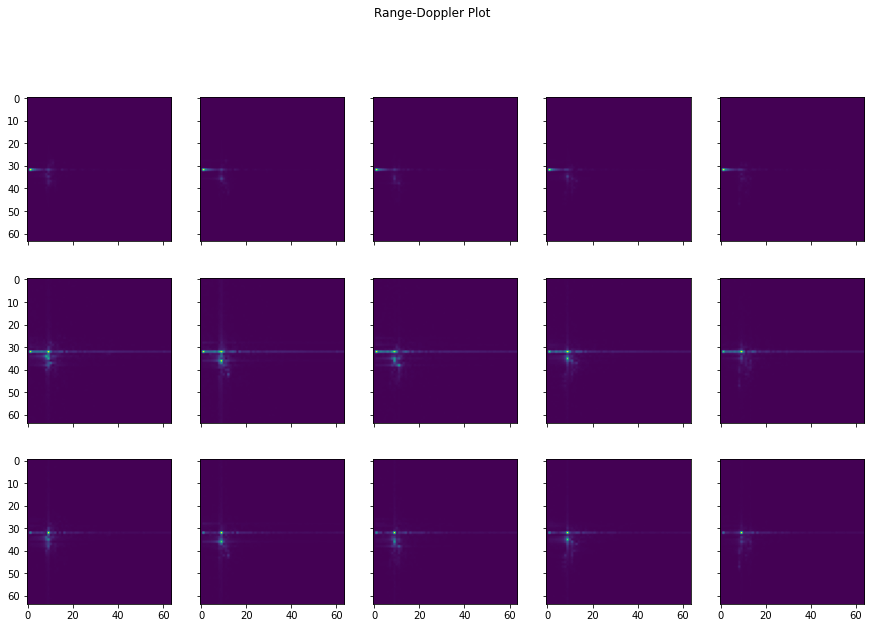

In [79]:
fig, axs = plot.subplots(3, 5,figsize=(15,10),sharex=True, sharey=  True)
fig.suptitle('Range-Doppler Plot')

for i in range(3):
    for j in range(5):
        axs[i, j].imshow(np.abs(range_doppler_map)[j,i,:,:])
        axs[i, j].set_aspect('equal')

plot.subplots_adjust(hspace=0)

In [146]:
copyarray0 = raw_data
copyarray0 = np.array(copyarray0)  # FOR NO PEOPLE
copyarray0.shape = (9000,64*128)
ones = np.ones((9000,1))*0
final0 = np.append(copyarray0,ones,axis=1)

df0 = pd.DataFrame(final0)
df0

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.466911,0.438584,0.419536,0.422955,0.434188,0.429792,0.410256,0.401465,0.413675,0.426374,...,0.473260,0.473748,0.485226,0.492308,0.485470,0.475702,0.476679,0.488400,0.491819,0.0
1,0.519658,0.498168,0.469841,0.461538,0.477167,0.491819,0.484005,0.464713,0.454945,0.467155,...,0.463980,0.456166,0.459829,0.466422,0.464469,0.456166,0.455678,0.462515,0.466422,0.0
2,0.487912,0.468864,0.459585,0.474969,0.494261,0.487912,0.470330,0.468376,0.481563,0.490842,...,0.466422,0.472772,0.480586,0.475702,0.468864,0.471551,0.479853,0.480830,0.470818,0.0
3,0.468376,0.440537,0.420757,0.421001,0.432234,0.429304,0.411722,0.401709,0.413187,0.427106,...,0.475214,0.472283,0.483516,0.491819,0.486447,0.475702,0.475702,0.487424,0.492796,0.0
4,0.518926,0.499634,0.470330,0.460073,0.476679,0.493284,0.485958,0.465446,0.454212,0.466422,...,0.463492,0.454701,0.458608,0.466422,0.464957,0.455189,0.453724,0.462027,0.467399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.516239,0.488889,0.460073,0.458852,0.482540,0.494750,0.480586,0.463004,0.461538,0.475214,...,0.461050,0.455678,0.463004,0.469841,0.463980,0.456166,0.459096,0.467399,0.467888,0.0
8996,0.480830,0.463980,0.465446,0.483516,0.492308,0.480342,0.465690,0.469841,0.485470,0.490354,...,0.469841,0.478388,0.481074,0.472283,0.467399,0.474725,0.483028,0.481074,0.470330,0.0
8997,0.459096,0.433700,0.423932,0.431746,0.437118,0.424420,0.406349,0.405372,0.422466,0.430769,...,0.475702,0.478144,0.488400,0.490354,0.483028,0.476190,0.480586,0.491819,0.493284,0.0
8998,0.515263,0.487912,0.458608,0.459096,0.482051,0.494261,0.480586,0.461538,0.458608,0.472283,...,0.461538,0.457631,0.463980,0.469841,0.464957,0.457143,0.459341,0.467888,0.468864,0.0


In [104]:
copyarray = raw_data

In [148]:
copyarray = raw_data
copyarray = np.array(copyarray)  # FOR 1 PERSON
copyarray.shape = (9000,64*128)
ones = np.ones((9000,1))

final1 = np.append(copyarray,ones,axis=1)

df1 = pd.DataFrame(final1)
df1

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.479121,0.478388,0.455678,0.421001,0.410256,0.426862,0.439805,0.427839,0.406105,0.402198,...,0.484982,0.485470,0.481074,0.483028,0.490598,0.491819,0.482784,0.473748,0.477900,1.0
1,0.485958,0.486447,0.495726,0.492308,0.471795,0.460562,0.468864,0.478632,0.476190,0.467643,...,0.466422,0.467643,0.462027,0.460317,0.464957,0.464957,0.460073,0.459341,0.465446,1.0
2,0.506960,0.508913,0.496703,0.480098,0.475702,0.487179,0.493773,0.485470,0.476190,0.472283,...,0.477656,0.471306,0.472772,0.478144,0.477656,0.473260,0.469841,0.472283,0.476679,1.0
3,0.478632,0.478388,0.457143,0.424908,0.414652,0.427839,0.439560,0.427106,0.406349,0.400488,...,0.487424,0.486935,0.481563,0.483761,0.491819,0.493284,0.482051,0.470818,0.476435,1.0
4,0.478144,0.476679,0.491331,0.494261,0.478632,0.468376,0.476190,0.482540,0.476190,0.462515,...,0.463248,0.464713,0.459585,0.460562,0.467888,0.469841,0.463492,0.458608,0.462027,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.510867,0.513797,0.506471,0.486935,0.473260,0.481563,0.487179,0.474481,0.457143,0.453724,...,0.469841,0.464957,0.463004,0.465690,0.467399,0.463492,0.457631,0.457143,0.464225,1.0
8996,0.512821,0.499145,0.473748,0.462027,0.477167,0.490354,0.482051,0.471795,0.476679,0.487668,...,0.471795,0.470574,0.476435,0.479365,0.476190,0.473016,0.473748,0.478632,0.478632,1.0
8997,0.488889,0.470818,0.434676,0.411233,0.420513,0.438095,0.435897,0.416117,0.407326,0.421490,...,0.484982,0.478632,0.480098,0.490354,0.493284,0.484005,0.474237,0.476923,0.487424,1.0
8998,0.507448,0.507692,0.496703,0.474725,0.463248,0.477656,0.488400,0.480586,0.465446,0.462027,...,0.469353,0.464957,0.461050,0.463980,0.467888,0.464225,0.458120,0.458120,0.464469,1.0


In [150]:
copyarray2 = raw_data
copyarray2 = np.array(copyarray2)  # FOR 2 PEOPLE
copyarray2.shape = (9000,64*128)
ones = np.ones((9000,1))*2
ones
final2 = np.append(copyarray2,ones,axis=1)

df2 = pd.DataFrame(final2)
df2

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.474237,0.461783,0.439316,0.419780,0.420024,0.428083,0.427839,0.417094,0.412943,0.418559,...,0.484737,0.479121,0.476435,0.483516,0.491819,0.491331,0.483028,0.479121,0.483516,2.0
1,0.497680,0.493773,0.490842,0.479853,0.466911,0.472283,0.484982,0.481074,0.465934,0.460562,...,0.471306,0.464713,0.459096,0.462027,0.466422,0.465446,0.461538,0.461783,0.466178,2.0
2,0.499145,0.492796,0.480586,0.473748,0.484493,0.497436,0.491819,0.474725,0.470818,0.480098,...,0.473748,0.468864,0.476190,0.480098,0.476190,0.475702,0.476190,0.477656,0.477656,2.0
3,0.477167,0.464713,0.441026,0.418559,0.419048,0.431258,0.432723,0.420024,0.411233,0.414652,...,0.488889,0.485470,0.479609,0.482540,0.489377,0.489621,0.481563,0.477656,0.482051,2.0
4,0.497680,0.496703,0.495238,0.484005,0.470574,0.473260,0.482051,0.480586,0.468864,0.463004,...,0.469841,0.466667,0.459096,0.459096,0.464713,0.464469,0.458608,0.457387,0.466178,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.485958,0.483028,0.489377,0.489866,0.476190,0.466178,0.470818,0.480342,0.479853,0.467399,...,0.468864,0.468132,0.466422,0.463980,0.463004,0.462027,0.462027,0.462515,0.464957,2.0
8996,0.501343,0.505983,0.498168,0.480342,0.474725,0.486935,0.496703,0.489377,0.472283,0.463004,...,0.471795,0.471795,0.473748,0.475702,0.476435,0.478632,0.479121,0.476190,0.474969,2.0
8997,0.478388,0.468376,0.446886,0.423199,0.419048,0.430769,0.437607,0.428327,0.412698,0.406349,...,0.484982,0.482051,0.479609,0.484493,0.491819,0.490842,0.482540,0.477167,0.481319,2.0
8998,0.487424,0.484493,0.491331,0.491575,0.475946,0.465446,0.471306,0.481563,0.481563,0.470330,...,0.465446,0.468620,0.468620,0.466667,0.462515,0.459585,0.459585,0.462027,0.463980,2.0


In [152]:
copyarray3 = raw_data
copyarray3 = np.array(copyarray2)  # FOR 3 PEOPLE
copyarray3.shape = (9000,64*128)
ones = np.ones((9000,1))*3
final3 = np.append(copyarray3,ones,axis=1)

df3 = pd.DataFrame(final3)
df3

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.474237,0.461783,0.439316,0.419780,0.420024,0.428083,0.427839,0.417094,0.412943,0.418559,...,0.484737,0.479121,0.476435,0.483516,0.491819,0.491331,0.483028,0.479121,0.483516,3.0
1,0.497680,0.493773,0.490842,0.479853,0.466911,0.472283,0.484982,0.481074,0.465934,0.460562,...,0.471306,0.464713,0.459096,0.462027,0.466422,0.465446,0.461538,0.461783,0.466178,3.0
2,0.499145,0.492796,0.480586,0.473748,0.484493,0.497436,0.491819,0.474725,0.470818,0.480098,...,0.473748,0.468864,0.476190,0.480098,0.476190,0.475702,0.476190,0.477656,0.477656,3.0
3,0.477167,0.464713,0.441026,0.418559,0.419048,0.431258,0.432723,0.420024,0.411233,0.414652,...,0.488889,0.485470,0.479609,0.482540,0.489377,0.489621,0.481563,0.477656,0.482051,3.0
4,0.497680,0.496703,0.495238,0.484005,0.470574,0.473260,0.482051,0.480586,0.468864,0.463004,...,0.469841,0.466667,0.459096,0.459096,0.464713,0.464469,0.458608,0.457387,0.466178,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.485958,0.483028,0.489377,0.489866,0.476190,0.466178,0.470818,0.480342,0.479853,0.467399,...,0.468864,0.468132,0.466422,0.463980,0.463004,0.462027,0.462027,0.462515,0.464957,3.0
8996,0.501343,0.505983,0.498168,0.480342,0.474725,0.486935,0.496703,0.489377,0.472283,0.463004,...,0.471795,0.471795,0.473748,0.475702,0.476435,0.478632,0.479121,0.476190,0.474969,3.0
8997,0.478388,0.468376,0.446886,0.423199,0.419048,0.430769,0.437607,0.428327,0.412698,0.406349,...,0.484982,0.482051,0.479609,0.484493,0.491819,0.490842,0.482540,0.477167,0.481319,3.0
8998,0.487424,0.484493,0.491331,0.491575,0.475946,0.465446,0.471306,0.481563,0.481563,0.470330,...,0.465446,0.468620,0.468620,0.466667,0.462515,0.459585,0.459585,0.462027,0.463980,3.0


In [155]:
all_labeled_data = pd.concat([df0,df1,df2,df3],axis=0)

In [167]:
all_labeled_data.to_csv(r'C:\Users\Chrysa\Desktop\LabeledDataFrame.csv', index = False)

In [201]:
df0


,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.466911,0.438584,0.419536,0.422955,0.434188,0.429792,0.410256,0.401465,0.413675,0.426374,...,0.473260,0.473748,0.485226,0.492308,0.485470,0.475702,0.476679,0.488400,0.491819,0.0
1,0.519658,0.498168,0.469841,0.461538,0.477167,0.491819,0.484005,0.464713,0.454945,0.467155,...,0.463980,0.456166,0.459829,0.466422,0.464469,0.456166,0.455678,0.462515,0.466422,0.0
2,0.487912,0.468864,0.459585,0.474969,0.494261,0.487912,0.470330,0.468376,0.481563,0.490842,...,0.466422,0.472772,0.480586,0.475702,0.468864,0.471551,0.479853,0.480830,0.470818,0.0
3,0.468376,0.440537,0.420757,0.421001,0.432234,0.429304,0.411722,0.401709,0.413187,0.427106,...,0.475214,0.472283,0.483516,0.491819,0.486447,0.475702,0.475702,0.487424,0.492796,0.0
4,0.518926,0.499634,0.470330,0.460073,0.476679,0.493284,0.485958,0.465446,0.454212,0.466422,...,0.463492,0.454701,0.458608,0.466422,0.464957,0.455189,0.453724,0.462027,0.467399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.517705,0.499634,0.470330,0.460073,0.474725,0.491087,0.485714,0.467399,0.457143,0.466422,...,0.464957,0.456654,0.460073,0.468376,0.466422,0.457143,0.456166,0.463004,0.467643,0.0
2996,0.490842,0.471306,0.462027,0.474725,0.491819,0.488400,0.470818,0.468132,0.479365,0.488400,...,0.468376,0.473748,0.481319,0.477167,0.469597,0.472772,0.480586,0.481563,0.473260,0.0
2997,0.468864,0.442002,0.422955,0.423199,0.433700,0.431746,0.414652,0.403907,0.414652,0.428327,...,0.476679,0.474725,0.484249,0.492308,0.487424,0.477411,0.477656,0.487912,0.493773,0.0
2998,0.519170,0.500611,0.471306,0.459585,0.475214,0.491819,0.486447,0.466911,0.456166,0.465934,...,0.464713,0.456166,0.458608,0.466422,0.466178,0.457143,0.455189,0.462027,0.467399,0.0


In [ ]:
testdf = testdf.drop(testdf[3000:8999],inplace=True)


In [246]:
testdf

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.466911,0.438584,0.419536,0.422955,0.434188,0.429792,0.410256,0.401465,0.413675,0.426374,...,0.473260,0.473748,0.485226,0.492308,0.485470,0.475702,0.476679,0.488400,0.491819,0.0
1,0.519658,0.498168,0.469841,0.461538,0.477167,0.491819,0.484005,0.464713,0.454945,0.467155,...,0.463980,0.456166,0.459829,0.466422,0.464469,0.456166,0.455678,0.462515,0.466422,0.0
2,0.487912,0.468864,0.459585,0.474969,0.494261,0.487912,0.470330,0.468376,0.481563,0.490842,...,0.466422,0.472772,0.480586,0.475702,0.468864,0.471551,0.479853,0.480830,0.470818,0.0
3,0.468376,0.440537,0.420757,0.421001,0.432234,0.429304,0.411722,0.401709,0.413187,0.427106,...,0.475214,0.472283,0.483516,0.491819,0.486447,0.475702,0.475702,0.487424,0.492796,0.0
4,0.518926,0.499634,0.470330,0.460073,0.476679,0.493284,0.485958,0.465446,0.454212,0.466422,...,0.463492,0.454701,0.458608,0.466422,0.464957,0.455189,0.453724,0.462027,0.467399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.517705,0.499634,0.470330,0.460073,0.474725,0.491087,0.485714,0.467399,0.457143,0.466422,...,0.464957,0.456654,0.460073,0.468376,0.466422,0.457143,0.456166,0.463004,0.467643,0.0
2996,0.490842,0.471306,0.462027,0.474725,0.491819,0.488400,0.470818,0.468132,0.479365,0.488400,...,0.468376,0.473748,0.481319,0.477167,0.469597,0.472772,0.480586,0.481563,0.473260,0.0
2997,0.468864,0.442002,0.422955,0.423199,0.433700,0.431746,0.414652,0.403907,0.414652,0.428327,...,0.476679,0.474725,0.484249,0.492308,0.487424,0.477411,0.477656,0.487912,0.493773,0.0
2998,0.519170,0.500611,0.471306,0.459585,0.475214,0.491819,0.486447,0.466911,0.456166,0.465934,...,0.464713,0.456166,0.458608,0.466422,0.466178,0.457143,0.455189,0.462027,0.467399,0.0


In [231]:
testdf1 =df1.copy()

In [232]:
testdf1.drop(testdf1.index[3000:8999],inplace=True)

In [234]:
testdf1

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.479121,0.478388,0.455678,0.421001,0.410256,0.426862,0.439805,0.427839,0.406105,0.402198,...,0.484982,0.485470,0.481074,0.483028,0.490598,0.491819,0.482784,0.473748,0.477900,1.0
1,0.485958,0.486447,0.495726,0.492308,0.471795,0.460562,0.468864,0.478632,0.476190,0.467643,...,0.466422,0.467643,0.462027,0.460317,0.464957,0.464957,0.460073,0.459341,0.465446,1.0
2,0.506960,0.508913,0.496703,0.480098,0.475702,0.487179,0.493773,0.485470,0.476190,0.472283,...,0.477656,0.471306,0.472772,0.478144,0.477656,0.473260,0.469841,0.472283,0.476679,1.0
3,0.478632,0.478388,0.457143,0.424908,0.414652,0.427839,0.439560,0.427106,0.406349,0.400488,...,0.487424,0.486935,0.481563,0.483761,0.491819,0.493284,0.482051,0.470818,0.476435,1.0
4,0.478144,0.476679,0.491331,0.494261,0.478632,0.468376,0.476190,0.482540,0.476190,0.462515,...,0.463248,0.464713,0.459585,0.460562,0.467888,0.469841,0.463492,0.458608,0.462027,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.495238,0.487912,0.485958,0.478144,0.464957,0.463004,0.468376,0.469841,0.465934,0.460073,...,0.465934,0.466422,0.466422,0.466911,0.466422,0.465201,0.462515,0.463004,0.465446,1.0
2996,0.499145,0.493284,0.479609,0.466911,0.470818,0.482051,0.484982,0.480098,0.472283,0.473748,...,0.479121,0.478144,0.479121,0.479121,0.477411,0.476190,0.476923,0.476190,0.470085,1.0
2997,0.484493,0.473260,0.452747,0.433211,0.432723,0.444444,0.446886,0.433211,0.421001,0.419780,...,0.465201,0.464225,0.466422,0.472772,0.480586,0.483761,0.482051,0.483761,0.493284,1.0
2998,0.492308,0.487424,0.489621,0.487424,0.478632,0.479121,0.488400,0.494017,0.487912,0.476679,...,0.465934,0.464469,0.460562,0.459341,0.460073,0.458120,0.454212,0.455189,0.460562,1.0


In [235]:
testdf2 =df2.copy()

In [236]:
testdf3 =df3.copy()

In [237]:
testdf2.drop(testdf2.index[2999:8999],inplace=True)

In [238]:
testdf3.drop(testdf3.index[2999:8999],inplace=True)

In [243]:
testdf3.drop(testdf3.index[2999],inplace=True)

In [247]:
all_labeled_data1 = pd.concat([testdf,testdf1,testdf2,testdf3],axis=0)

In [251]:
all_labeled_data1.to_csv(r'C:\Users\Chrysa\Desktop\LabeledDataFrame.csv', index = False)

In [249]:
all_labeled_data1

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,0.466911,0.438584,0.419536,0.422955,0.434188,0.429792,0.410256,0.401465,0.413675,0.426374,...,0.473260,0.473748,0.485226,0.492308,0.485470,0.475702,0.476679,0.488400,0.491819,0.0
1,0.519658,0.498168,0.469841,0.461538,0.477167,0.491819,0.484005,0.464713,0.454945,0.467155,...,0.463980,0.456166,0.459829,0.466422,0.464469,0.456166,0.455678,0.462515,0.466422,0.0
2,0.487912,0.468864,0.459585,0.474969,0.494261,0.487912,0.470330,0.468376,0.481563,0.490842,...,0.466422,0.472772,0.480586,0.475702,0.468864,0.471551,0.479853,0.480830,0.470818,0.0
3,0.468376,0.440537,0.420757,0.421001,0.432234,0.429304,0.411722,0.401709,0.413187,0.427106,...,0.475214,0.472283,0.483516,0.491819,0.486447,0.475702,0.475702,0.487424,0.492796,0.0
4,0.518926,0.499634,0.470330,0.460073,0.476679,0.493284,0.485958,0.465446,0.454212,0.466422,...,0.463492,0.454701,0.458608,0.466422,0.464957,0.455189,0.453724,0.462027,0.467399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.495726,0.496703,0.501099,0.489621,0.470818,0.469841,0.479121,0.479121,0.469841,0.462515,...,0.468132,0.465446,0.462515,0.462027,0.465446,0.465934,0.460806,0.457875,0.462515,3.0
2996,0.510867,0.506960,0.488400,0.470818,0.477900,0.494750,0.492796,0.480830,0.475458,0.477656,...,0.473260,0.470818,0.476190,0.480098,0.480098,0.476679,0.472772,0.475214,0.480098,3.0
2997,0.490842,0.478632,0.446886,0.420024,0.421001,0.438828,0.443956,0.426862,0.407814,0.409768,...,0.487668,0.482540,0.477900,0.486447,0.498168,0.495726,0.483028,0.476679,0.483028,3.0
2998,0.488889,0.492308,0.498168,0.488889,0.471306,0.472283,0.485470,0.487424,0.475702,0.462027,...,0.465446,0.463004,0.461538,0.463492,0.465934,0.463980,0.460073,0.460562,0.466422,3.0
